In [1]:
import rerun as rr
import genjax
import os
import numpy as np
import jax.numpy as jnp
import jax
from b3d import Pose
import b3d
from tqdm import tqdm
import trimesh
import pytest
from PIL import Image
import matplotlib.pyplot as plt
import matplotlib
from b3d.bayes3d.image_likelihoods import gaussian_iid_pix_likelihood_vec, threedp3_gmm_likelihood_vec, kray_likelihood_intermediate_vec



In [2]:
## L2 distance test 

PORT = 8812
rr.init("233")
rr.connect(addr=f"127.0.0.1:{PORT}")

In [3]:
## posterior grows as object is moved into distance

In [4]:
mesh_path = os.path.join(
    b3d.get_root_path(), "assets/shared_data_bucket/025_mug/textured.obj"
)
mesh = trimesh.load(mesh_path)
mesh.vertices = mesh.vertices - mesh.vertices.mean(axis=0)

object_library = b3d.MeshLibrary.make_empty_library()
object_library.add_trimesh(mesh)

h,w,fx,fy,cx,cy = 50, 50, 100.0, 100.0, 25.0, 25.0
renderers = [
    b3d.RendererOriginal(scale * h, scale *w, scale * fx, scale * fy, scale * cx, scale * cy, 0.01, 10.0)
    for scale in [9]
]

/opt/conda/envs/b3d2/lib/python3.12/site-packages/trimesh/grouping.py:99: RuntimeWarning: invalid value encountered in cast
  stacked = np.column_stack(stacked).round().astype(np.int64)


In [5]:
linear_pose_from_points = lambda points1, points2, alpha: b3d.Pose.from_position_and_target(
    jnp.array([0.0, -0.8, 0.1]),
    jnp.zeros(3)
).inv() @ b3d.Pose.from_translation((1 - alpha) * points1 + alpha * points2 )



def render_rgbd_many(renderer, vertices, faces, attributes):
    return renderer.render_many(
        vertices,
        faces,
        jnp.concatenate([attributes, vertices[...,-1:]],axis=-1)
    )


In [6]:

# gaussian iid args
gaussian_iid_pix_likelihood_args = {'rgb_tolerance': 50.0,
                   'depth_tolerance': 0.05,
                   'outlier_prob': 0.01}

# GMM args
threedp3_gmm_likelihood_args = {'variance': 0.01,
                   'outlier_prob': 0.1,
                   'outlier_volume': 10**3,
                   #'filter_size': 3,
                   'intrinsics': (100,100,200.0,200.0,50.0,50.0,0.01,10.0,)}

# ray-tracing likelihood args
kray_likelihood_args = {'color_tolerance': 50.0, #100
                    'depth_tolerance': 0.01, #0.005
                    'inlier_score': 5, #2.5,
                    'outlier_prob': 0.005,
                    'multiplier': 1.0, # 10000.0
                    'intrinsics': (100,100,200.0,200.0,50.0,50.0,0.01,10.0,)}



<>:68: SyntaxWarning: invalid escape sequence '\s'
<>:68: SyntaxWarning: invalid escape sequence '\s'
<>:68: SyntaxWarning: invalid escape sequence '\s'
<>:68: SyntaxWarning: invalid escape sequence '\s'
/var/tmp/ipykernel_106642/1079516751.py:68: SyntaxWarning: invalid escape sequence '\s'
  title = "Posterior conditioned on two mugs: \ncolor $\sigma$: " + str(rgb_noise_level) + ", depth $\sigma$: " + str(depth_noise_level)
/var/tmp/ipykernel_106642/1079516751.py:68: SyntaxWarning: invalid escape sequence '\s'
  title = "Posterior conditioned on two mugs: \ncolor $\sigma$: " + str(rgb_noise_level) + ", depth $\sigma$: " + str(depth_noise_level)


<Figure size 640x480 with 0 Axes>

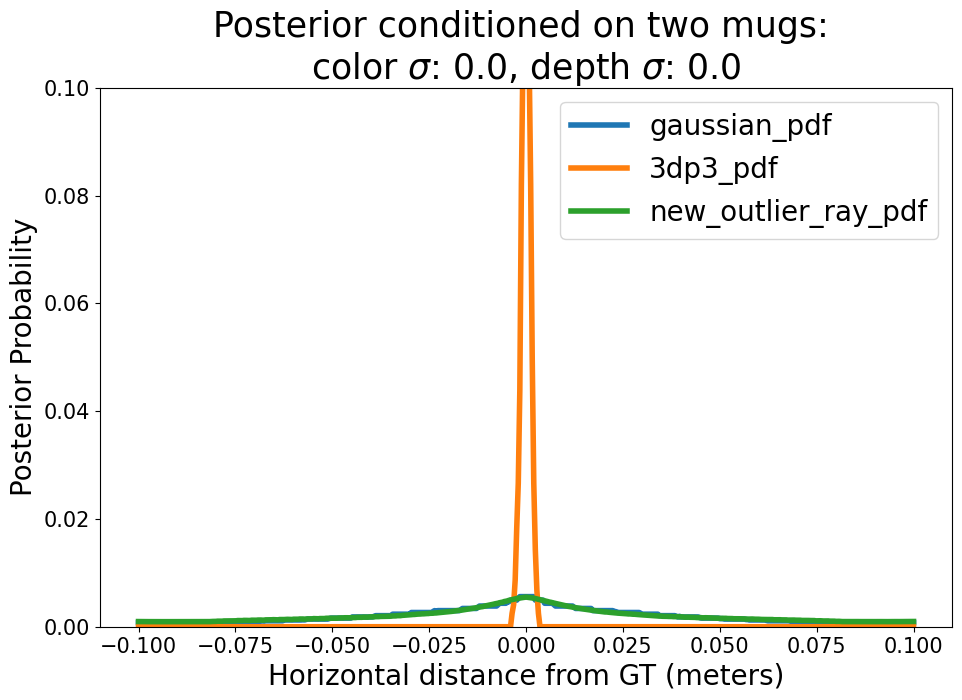

<Figure size 640x480 with 0 Axes>

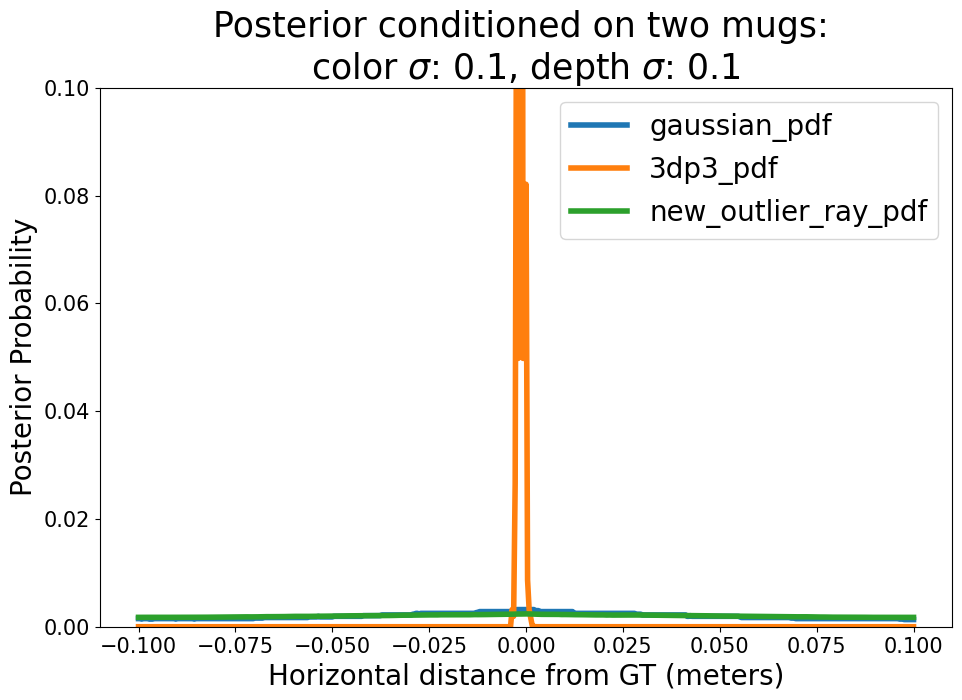

<Figure size 640x480 with 0 Axes>

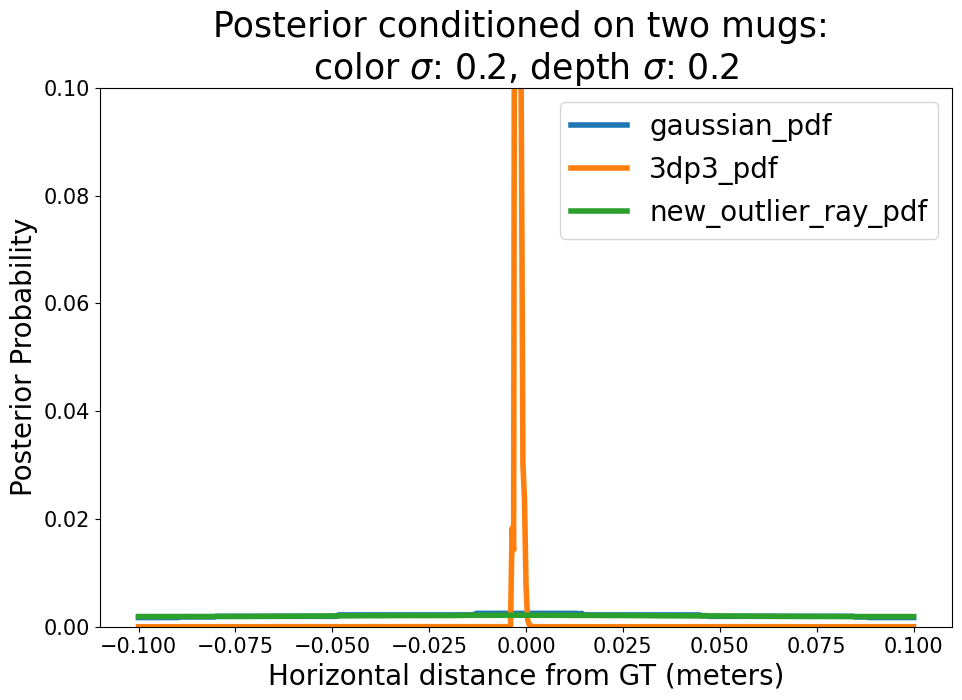

In [7]:
# sweep y from -0.25 to 1.5
num_noise_points = 3
rgb_noise_levels = np.linspace(0,0.2,num_noise_points) 
depth_noise_levels = np.linspace(0,0.2,num_noise_points) 
key = jax.random.PRNGKey(0)

gt_images = []
gt_depths = []

num_points = 501


for (rgb_noise_level, depth_noise_level) in zip(rgb_noise_levels, depth_noise_levels):
    distance = 0.25
    point1 = jnp.array([-0.1,distance,0])
    point2 = jnp.array([0.1,distance,0])

    # 0.1 is horizontal range

    alphas = jnp.linspace(0, 1, num_points)
    vec_fun = jax.vmap(linear_pose_from_points, (None, None, 0))

    linear_poses = vec_fun(point1, point2, alphas)
    transformed_vertices = jax.vmap(lambda i: linear_poses[i].apply(object_library.vertices))(jnp.arange(len(linear_poses)))

    N = len(linear_poses)

    all_images = [
            render_rgbd_many(r,
            transformed_vertices,
            object_library.faces,
            jnp.tile(object_library.attributes, (N,1,1)),
        )
        for r in [renderers[0]]
    ]


    images = all_images[0]
    rendered_imgs = images
    gt_image = images[N//2,...,:3]
    gt_image = jax.random.normal(key, shape=gt_image.shape) * rgb_noise_level + gt_image
    gt_images.append(gt_image)
    key, _ = jax.random.split(key)

    gt_image_depth = np.array(images[N//2,...,3])
    gt_image_depth[gt_image_depth==0] = 10.0
    gt_image_depth = jnp.array(gt_image_depth)
    gt_image_depth = jax.random.normal(
        key, shape=gt_image_depth.shape
    ) * depth_noise_level + gt_image_depth
    gt_depths.append(gt_image_depth)

    observed_image  =  jnp.concatenate([gt_image, gt_image_depth[...,None]], axis=-1)


    gaussian_logpdfs, _ = gaussian_iid_pix_likelihood_vec(observed_image, rendered_imgs,  gaussian_iid_pix_likelihood_args)
    threedp3_logpdfs, _ = threedp3_gmm_likelihood_vec(observed_image, rendered_imgs,  threedp3_gmm_likelihood_args)
    ray_outlier_logpdfs, _ = kray_likelihood_intermediate_vec(observed_image, rendered_imgs,  kray_likelihood_args)

    plt.figure()
    fig, axes = plt.subplots(1, 1, figsize=(11, 7))
    distances = linear_poses.pos[:,0]
    axes.plot(distances, b3d.normalize_log_scores(gaussian_logpdfs), alpha=1, linewidth=4, label='gaussian_pdf')
    axes.plot(distances, b3d.normalize_log_scores(threedp3_logpdfs), alpha=1, linewidth=4, label='3dp3_pdf')
    axes.plot(distances, b3d.normalize_log_scores(ray_outlier_logpdfs), alpha=1, linewidth=4, label='new_outlier_ray_pdf')
    num_ticks = 3

    title = "Posterior conditioned on two mugs: \ncolor $\sigma$: " + str(rgb_noise_level) + ", depth $\sigma$: " + str(depth_noise_level)

    plt.title(title, fontsize=25)
    plt.legend(fontsize=20)
    plt.xlabel("Horizontal distance from GT (meters)", fontsize=20)
    plt.ylabel("Posterior Probability", fontsize=20)
    axes.tick_params(axis='x', labelsize=15)
    axes.tick_params(axis='y', labelsize=15)
    axes.set_ylim(0.0, 0.1)


<>:66: SyntaxWarning: invalid escape sequence '\s'
<>:66: SyntaxWarning: invalid escape sequence '\s'
<>:66: SyntaxWarning: invalid escape sequence '\s'
<>:66: SyntaxWarning: invalid escape sequence '\s'
/var/tmp/ipykernel_106642/3468351267.py:66: SyntaxWarning: invalid escape sequence '\s'
  label="color $\sigma$: " + str(rgb_noise_level) + ", depth $\sigma$: " + str(depth_noise_level))
/var/tmp/ipykernel_106642/3468351267.py:66: SyntaxWarning: invalid escape sequence '\s'
  label="color $\sigma$: " + str(rgb_noise_level) + ", depth $\sigma$: " + str(depth_noise_level))


<Figure size 640x480 with 0 Axes>

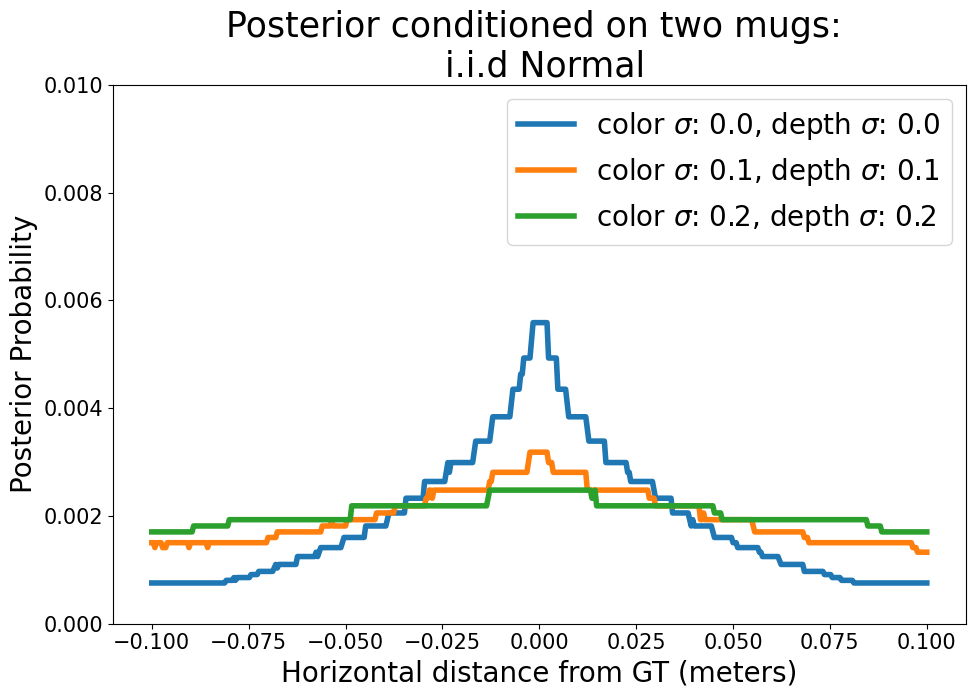

<Figure size 640x480 with 0 Axes>

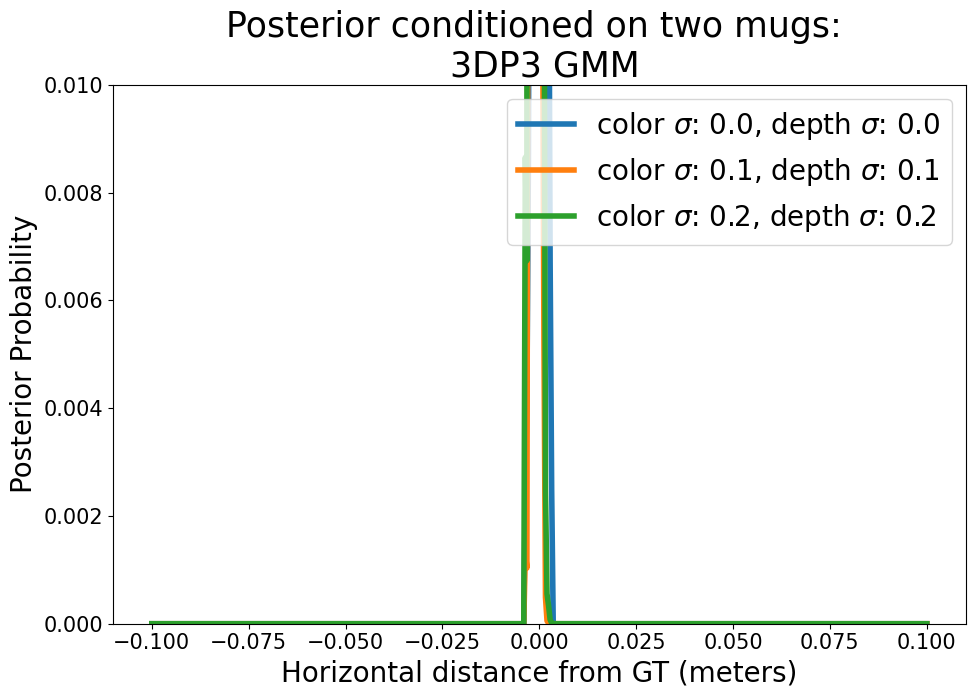

<Figure size 640x480 with 0 Axes>

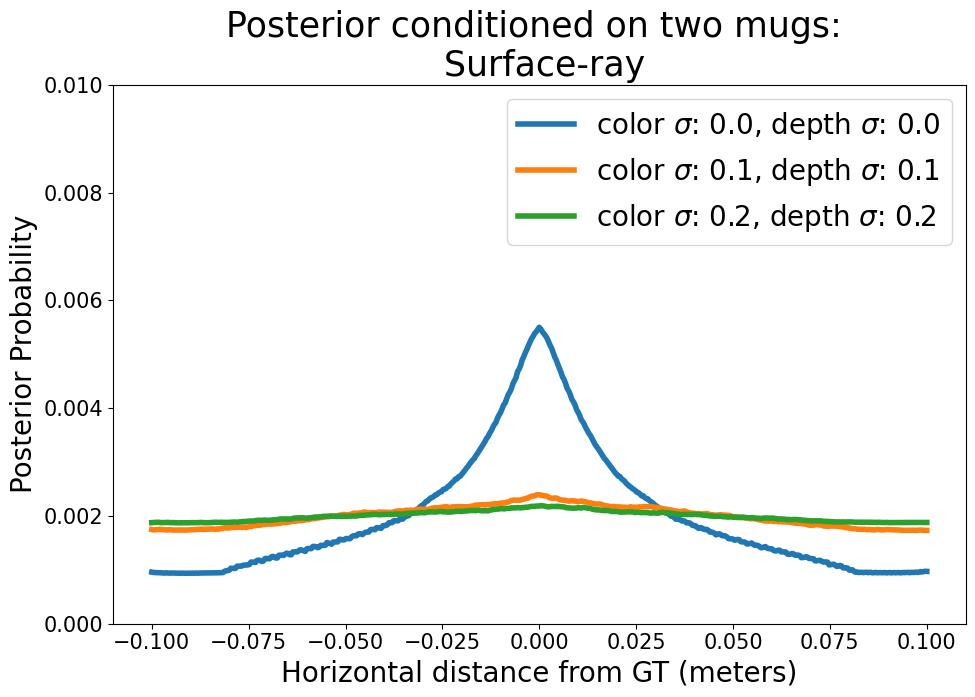

In [8]:
# sweep y from -0.25 to 1.5
num_noise_points = 3
rgb_noise_levels = np.linspace(0,0.2,num_noise_points) 
depth_noise_levels = np.linspace(0,0.2,num_noise_points) 
key = jax.random.PRNGKey(0)

gt_images = []
gt_image_depths = []

models = [gaussian_iid_pix_likelihood_vec, threedp3_gmm_likelihood_vec, kray_likelihood_intermediate_vec]
model_names = ['i.i.d Normal', '3DP3 GMM', 'Surface-ray']
model_args = [gaussian_iid_pix_likelihood_args, threedp3_gmm_likelihood_args, kray_likelihood_args]
scores = []

#
for model_ind, model in enumerate(models):
    distance = 0.25
    point1 = jnp.array([-0.1,distance,0])
    point2 = jnp.array([0.1,distance,0])

    # 0.1 is horizontal range

    alphas = jnp.linspace(0, 1, num_points)
    vec_fun = jax.vmap(linear_pose_from_points, (None, None, 0))

    linear_poses = vec_fun(point1, point2, alphas)
    transformed_vertices = jax.vmap(lambda i: linear_poses[i].apply(object_library.vertices))(jnp.arange(len(linear_poses)))

    N = len(linear_poses)

    all_images = [
            render_rgbd_many(r,
            transformed_vertices,
            object_library.faces,
            jnp.tile(object_library.attributes, (N,1,1)),
        )
        for r in [renderers[0]]
    ]

    plt.figure()
    fig, axes = plt.subplots(1, 1, figsize=(11, 7))
    distances = linear_poses.pos[:,0]
    model_scores = []

    for (rgb_noise_level, depth_noise_level) in zip(rgb_noise_levels, depth_noise_levels):
        images = all_images[0]
        rendered_imgs = images
        gt_image = images[N//2,...,:3]
        gt_image = jax.random.normal(key, shape=gt_image.shape) * rgb_noise_level + gt_image
        gt_images.append(gt_image)
        key, _ = jax.random.split(key)

        gt_image_depth = np.array(images[N//2,...,3])
        gt_image_depth[gt_image_depth==0] = 10.0
        gt_image_depth = jnp.array(gt_image_depth)
        gt_image_depth = jax.random.normal(
            key, shape=gt_image_depth.shape
        ) * depth_noise_level + gt_image_depth
        gt_image_depths.append(gt_image_depth)

        observed_image  =  jnp.concatenate([gt_image, gt_image_depth[...,None]], axis=-1)

        logpdfs, _ = model(observed_image, rendered_imgs,  model_args[model_ind])
        model_scores.append(logpdfs)
        axes.plot(distances, b3d.normalize_log_scores(logpdfs), alpha=1, linewidth=4, 
                  label="color $\sigma$: " + str(rgb_noise_level) + ", depth $\sigma$: " + str(depth_noise_level))
    scores.append(model_scores)

    num_ticks = 3

    title = "Posterior conditioned on two mugs: \n " + model_names[model_ind] 

    plt.title(title, fontsize=25)
    plt.legend(fontsize=20)
    plt.xlabel("Horizontal distance from GT (meters)", fontsize=20)
    plt.ylabel("Posterior Probability", fontsize=20)
    axes.tick_params(axis='x', labelsize=15)
    axes.tick_params(axis='y', labelsize=15)
    axes.set_ylim(0.0, 0.01)
scores = jnp.array(scores)

<>:84: SyntaxWarning: invalid escape sequence '\s'
<>:84: SyntaxWarning: invalid escape sequence '\s'
<>:84: SyntaxWarning: invalid escape sequence '\s'
<>:84: SyntaxWarning: invalid escape sequence '\s'
/var/tmp/ipykernel_106642/2349814831.py:84: SyntaxWarning: invalid escape sequence '\s'
  label="color $\sigma$: " + str(rgb_noise_level) + ", depth $\sigma$: " + str(depth_noise_level))
/var/tmp/ipykernel_106642/2349814831.py:84: SyntaxWarning: invalid escape sequence '\s'
  label="color $\sigma$: " + str(rgb_noise_level) + ", depth $\sigma$: " + str(depth_noise_level))


<Figure size 640x480 with 0 Axes>

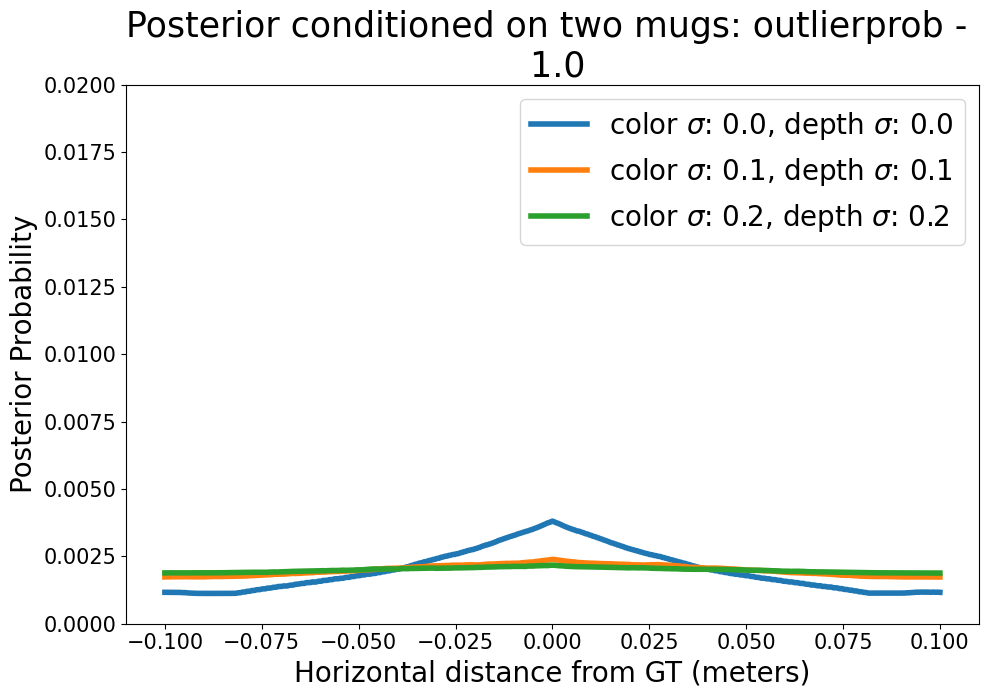

<Figure size 640x480 with 0 Axes>

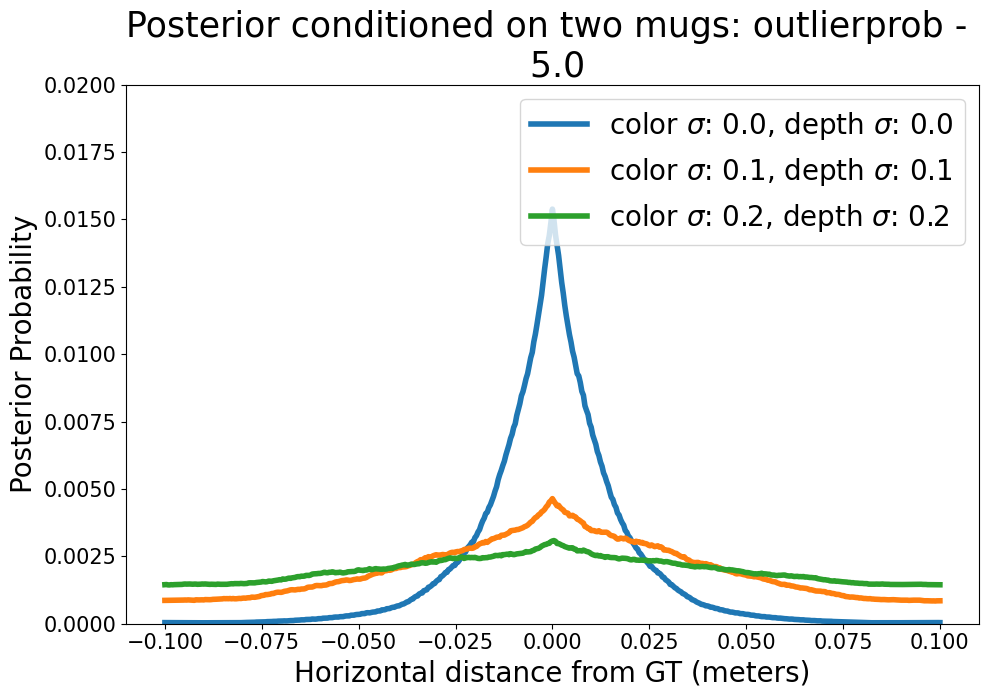

<Figure size 640x480 with 0 Axes>

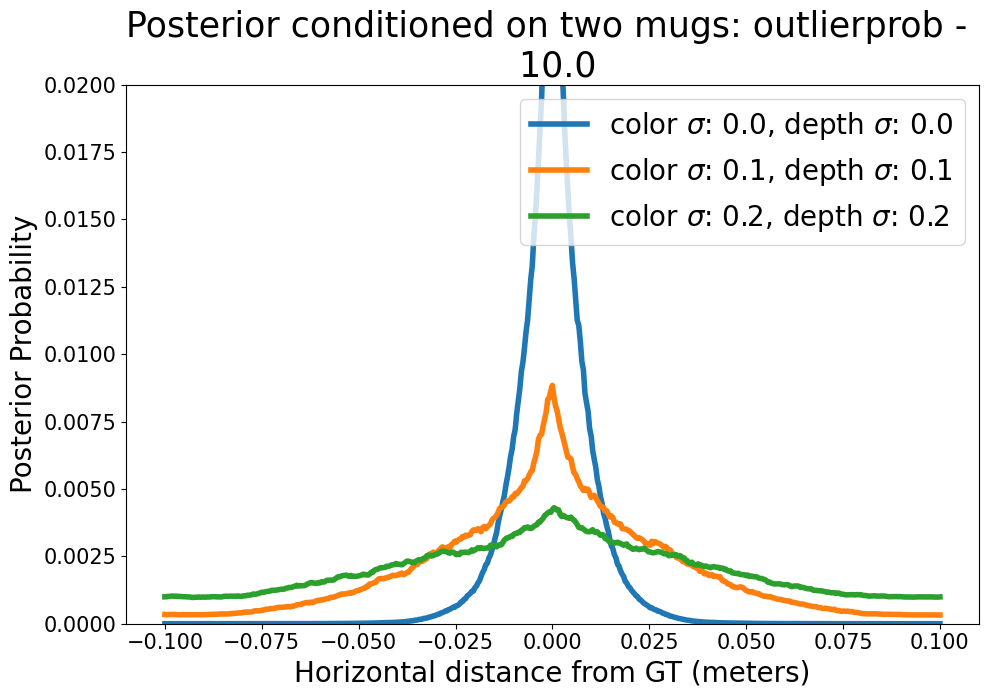

In [9]:
# ray-tracing likelihood args
# kray_likelihood_args = [{'color_tolerance': 50.0, #100
#                     'depth_tolerance': 0.01, #0.005
#                     'inlier_score': 5, #2.5,
#                     'outlier_prob': 0.005,
#                     'multiplier': 1.0, # 10000.0
#                     'intrinsics': (100,100,200.0,200.0,50.0,50.0,0.01,10.0,)}]

sweep_args = [1.0, 5.0, 10.0] # [0.005, 0.05, 0.5]

# sweep y from -0.25 to 1.5
num_noise_points = 3
rgb_noise_levels = np.linspace(0,0.2,num_noise_points) 
depth_noise_levels = np.linspace(0,0.2,num_noise_points) 
key = jax.random.PRNGKey(0)

gt_images = []
gt_image_depths = []

models = [gaussian_iid_pix_likelihood_vec, threedp3_gmm_likelihood_vec, kray_likelihood_intermediate_vec]
model_names = ['i.i.d Normal', '3DP3 GMM', 'Surface-ray']
model_args = [gaussian_iid_pix_likelihood_args, threedp3_gmm_likelihood_args, kray_likelihood_args]
scores = []

#
for sweep_arg in sweep_args:
    kray_likelihood_args = {'color_tolerance': 50.0, #100
                        'depth_tolerance': 0.02, #0.005
                        'inlier_score': 2.5,
                        'outlier_prob': 0.005,
                        'multiplier': sweep_arg, # 1.0, # 10000.0
                        'intrinsics': (100,100,200.0,200.0,50.0,50.0,0.01,10.0,)}

    model = models[2]
    distance = 0.25
    point1 = jnp.array([-0.1,distance,0])
    point2 = jnp.array([0.1,distance,0])

    # 0.1 is horizontal range

    alphas = jnp.linspace(0, 1, num_points)
    vec_fun = jax.vmap(linear_pose_from_points, (None, None, 0))

    linear_poses = vec_fun(point1, point2, alphas)
    transformed_vertices = jax.vmap(lambda i: linear_poses[i].apply(object_library.vertices))(jnp.arange(len(linear_poses)))

    N = len(linear_poses)

    all_images = [
            render_rgbd_many(r,
            transformed_vertices,
            object_library.faces,
            jnp.tile(object_library.attributes, (N,1,1)),
        )
        for r in [renderers[0]]
    ]

    plt.figure()
    fig, axes = plt.subplots(1, 1, figsize=(11, 7))
    distances = linear_poses.pos[:,0]
    model_scores = []

    for (rgb_noise_level, depth_noise_level) in zip(rgb_noise_levels, depth_noise_levels):
        images = all_images[0]
        rendered_imgs = images
        gt_image = images[N//2,...,:3]
        gt_image = jax.random.normal(key, shape=gt_image.shape) * rgb_noise_level + gt_image
        gt_images.append(gt_image)
        key, _ = jax.random.split(key)

        gt_image_depth = np.array(images[N//2,...,3])
        gt_image_depth[gt_image_depth==0] = 10.0
        gt_image_depth = jnp.array(gt_image_depth)
        gt_image_depth = jax.random.normal(
            key, shape=gt_image_depth.shape
        ) * depth_noise_level + gt_image_depth
        gt_image_depths.append(gt_image_depth)

        observed_image  =  jnp.concatenate([gt_image, gt_image_depth[...,None]], axis=-1)

        logpdfs, _ = model(observed_image, rendered_imgs,  kray_likelihood_args)
        model_scores.append(logpdfs)
        axes.plot(distances, b3d.normalize_log_scores(logpdfs), alpha=1, linewidth=4, 
                  label="color $\sigma$: " + str(rgb_noise_level) + ", depth $\sigma$: " + str(depth_noise_level))
    scores.append(model_scores)

    num_ticks = 3

    title = "Posterior conditioned on two mugs: outlierprob - \n " + str(sweep_arg)

    plt.title(title, fontsize=25)
    plt.legend(fontsize=20)
    plt.xlabel("Horizontal distance from GT (meters)", fontsize=20)
    plt.ylabel("Posterior Probability", fontsize=20)
    axes.tick_params(axis='x', labelsize=15)
    axes.tick_params(axis='y', labelsize=15)
    axes.set_ylim(0.0, 0.02)
scores = jnp.array(scores)

In [10]:
# gaussian iid args
gaussian_iid_pix_likelihood_args = {'rgb_tolerance': 50.0,
                   'depth_tolerance': 0.025,
                   'outlier_prob': 0.01}

# GMM args
threedp3_gmm_likelihood_args = {'variance': 0.1,
                   'outlier_prob': 0.1,
                   'outlier_volume': 10**3,
                   'filter_size': 3,
                   'intrinsics': (100,100,200.0,200.0,50.0,50.0,0.01,10.0,)}

# ray-tracing likelihood args
kray_likelihood_args = {'color_tolerance': 50.0,
                    'depth_tolerance': 0.01,
                    'inlier_score': 25, #2.5,
                    'outlier_prob': 0.005,
                    'multiplier': 10.0,
                    'intrinsics': (100,100,200.0,200.0,50.0,50.0,0.01,10.0,)}


In [11]:
models = [gaussian_iid_pix_likelihood_vec, threedp3_gmm_likelihood_vec, kray_likelihood_intermediate_vec]
model_names = ['i.i.d Normal', '3DP3 GMM', 'Surface-ray']
model_args = [gaussian_iid_pix_likelihood_args, threedp3_gmm_likelihood_args, kray_likelihood_args]

In [12]:
num_points = 4001
distance = 0.25
observed_images = []
scale = 9
renderer = b3d.RendererOriginal(scale * h, scale *w, scale * fx, scale * fy, scale * cx, scale * cy, 0.01, 10.0)

for n_ind, (rgb_noise_level, depth_noise_level) in enumerate(zip(rgb_noise_levels, depth_noise_levels)):
    gt_pose = b3d.Pose.from_position_and_target(jnp.array([0.0, -0.8, 0.1]), jnp.zeros(3)).inv() @ b3d.Pose.from_translation(jnp.array([0,distance,0]))
    transformed_vertices = gt_pose.apply(object_library.vertices)[None,...]
    images = render_rgbd_many(renderer,transformed_vertices,object_library.faces, jnp.tile(object_library.attributes, (1,1,1)))
    gt_image = images[0,...,:3]
    gt_image = jax.random.normal(key, shape=gt_image.shape) * rgb_noise_level + gt_image
    gt_image_depth = np.array(images[0,...,3])
    gt_image_depth[gt_image_depth==0] = 10.0
    gt_image_depth = jnp.array(gt_image_depth)
    gt_image_depth = jax.random.normal(
        key, shape=gt_image_depth.shape
    ) * depth_noise_level + gt_image_depth
    observed_images.append(jnp.concatenate([gt_image, gt_image_depth[...,None]], axis=-1))

vec_fun = jax.vmap(linear_pose_from_points, (None, None, 0))

<>:21: SyntaxWarning: invalid escape sequence '\s'
<>:21: SyntaxWarning: invalid escape sequence '\s'
<>:21: SyntaxWarning: invalid escape sequence '\s'
<>:21: SyntaxWarning: invalid escape sequence '\s'
/var/tmp/ipykernel_106642/3592735576.py:21: SyntaxWarning: invalid escape sequence '\s'
  im_dim_str = "$\sigma_c$: " + str(rgb_noise_level) + ", $\sigma_d$: " + str(depth_noise_level)
/var/tmp/ipykernel_106642/3592735576.py:21: SyntaxWarning: invalid escape sequence '\s'
  im_dim_str = "$\sigma_c$: " + str(rgb_noise_level) + ", $\sigma_d$: " + str(depth_noise_level)


<Figure size 640x480 with 0 Axes>

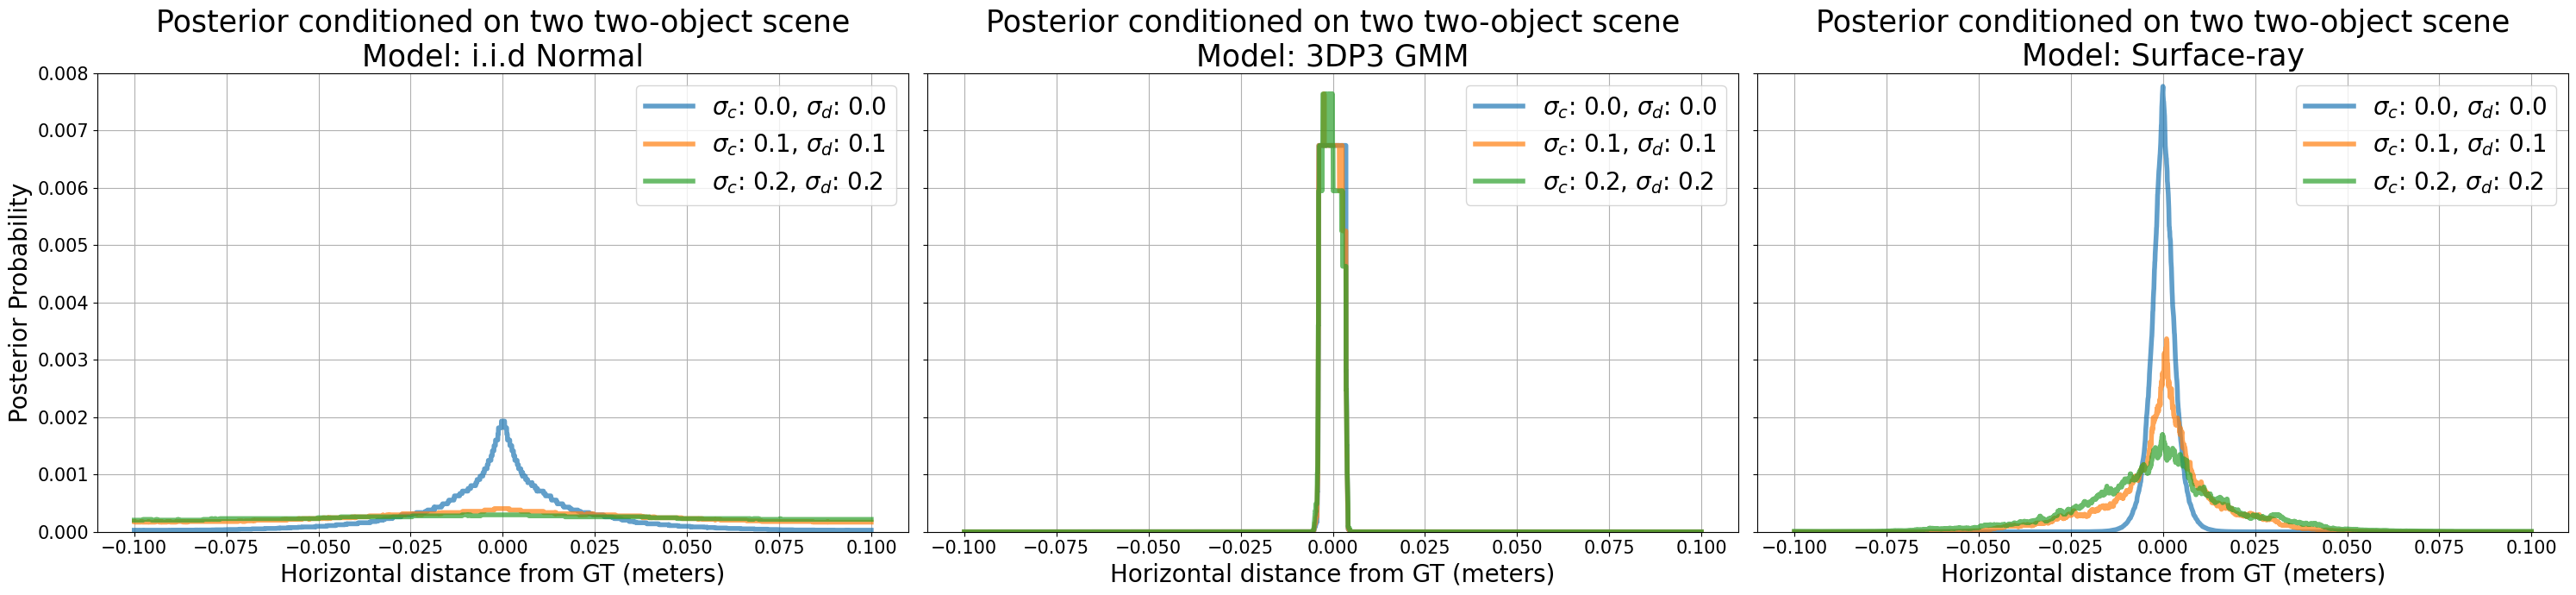

In [14]:
# sweep y from -0.25 to 1.5
plt.figure()
fig, axes = plt.subplots(1, len(models), figsize=(10*len(models), 7))
for model_ind, model in enumerate(models):
    ax = axes[model_ind]
    for n_ind, (rgb_noise_level, depth_noise_level) in enumerate(zip(rgb_noise_levels, depth_noise_levels)):
        horizontal_range = 0.1
        point1 = jnp.array([-horizontal_range,distance,0])
        point2 = jnp.array([horizontal_range,distance,0])
        alphas = jnp.linspace(0, 1, num_points)
        linear_poses_batches = vec_fun(point1, point2, alphas).split(10)
        logpdfs = []
        translations = []
        for linear_poses in linear_poses_batches:
            transformed_vertices = jax.vmap(lambda i: linear_poses[i].apply(object_library.vertices))(jnp.arange(len(linear_poses)))
            rendered_imgs = render_rgbd_many(renderer,transformed_vertices,object_library.faces, jnp.tile(object_library.attributes, (len(linear_poses),1,1)))
            logpdfs.append(model(observed_images[n_ind], rendered_imgs,  model_args[model_ind])[0])
            translations.append(linear_poses.pos[:,0])
        logpdfs = jnp.concatenate(logpdfs)
        translations = jnp.concatenate(translations)
        im_dim_str = "$\sigma_c$: " + str(rgb_noise_level) + ", $\sigma_d$: " + str(depth_noise_level)
        ax.plot(translations, b3d.normalize_log_scores(logpdfs), alpha=0.7, linewidth=4, label=im_dim_str)
    title = "Posterior conditioned on two two-object scene\nModel: " + str(model_names[model_ind])
    ax.set_title(title, fontsize=25)
    ax.tick_params(axis='x', labelsize=15)
    ax.tick_params(axis='y', labelsize=15)
    ax.legend(fontsize=20)
    ax.set_xlabel("Horizontal distance from GT (meters)", fontsize=20)
    ax.grid(True)
    if model_ind == 0:
        ax.set_ylabel("Posterior Probability", fontsize=20)
    else:
        ax.yaxis.set_ticklabels([])
    ax.set_ylim(0.0, 0.008)
fig.tight_layout()

<>:3: SyntaxWarning: invalid escape sequence '\s'
<>:3: SyntaxWarning: invalid escape sequence '\s'
<>:3: SyntaxWarning: invalid escape sequence '\s'
<>:3: SyntaxWarning: invalid escape sequence '\s'
/var/tmp/ipykernel_104113/1854635855.py:3: SyntaxWarning: invalid escape sequence '\s'
  plt.title("conditioned image: \ncolor $\sigma$: " + str(rgb_noise_level) + ", depth $\sigma$: " + str(depth_noise_level), fontsize=20)
/var/tmp/ipykernel_104113/1854635855.py:3: SyntaxWarning: invalid escape sequence '\s'
  plt.title("conditioned image: \ncolor $\sigma$: " + str(rgb_noise_level) + ", depth $\sigma$: " + str(depth_noise_level), fontsize=20)
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


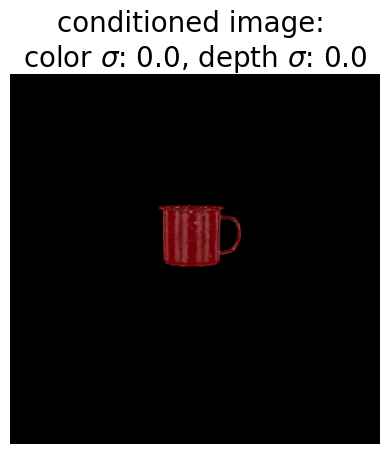

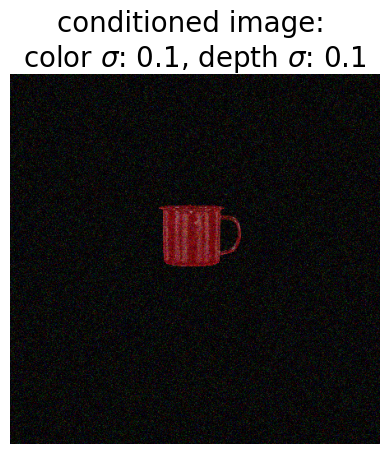

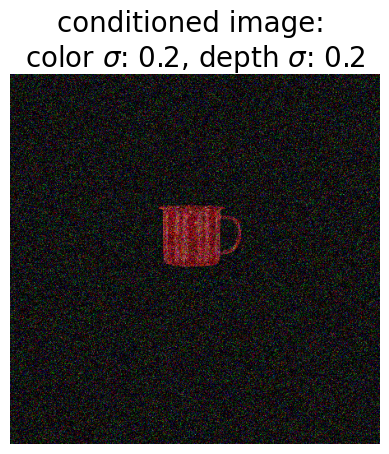

In [ ]:
for noise_ind, (rgb_noise_level, depth_noise_level) in enumerate(zip(rgb_noise_levels, depth_noise_levels)):
    plt.figure()
    plt.title("conditioned image: \ncolor $\sigma$: " + str(rgb_noise_level) + ", depth $\sigma$: " + str(depth_noise_level), fontsize=20)
    plt.imshow(gt_images[noise_ind])
    plt.axis('off')

<>:3: SyntaxWarning: invalid escape sequence '\s'
<>:3: SyntaxWarning: invalid escape sequence '\s'
<>:3: SyntaxWarning: invalid escape sequence '\s'
<>:3: SyntaxWarning: invalid escape sequence '\s'
/var/tmp/ipykernel_104113/524436486.py:3: SyntaxWarning: invalid escape sequence '\s'
  plt.title("conditioned image: \ncolor $\sigma$: " + str(rgb_noise_level) + ", depth $\sigma$: " + str(depth_noise_level), fontsize=20)
/var/tmp/ipykernel_104113/524436486.py:3: SyntaxWarning: invalid escape sequence '\s'
  plt.title("conditioned image: \ncolor $\sigma$: " + str(rgb_noise_level) + ", depth $\sigma$: " + str(depth_noise_level), fontsize=20)


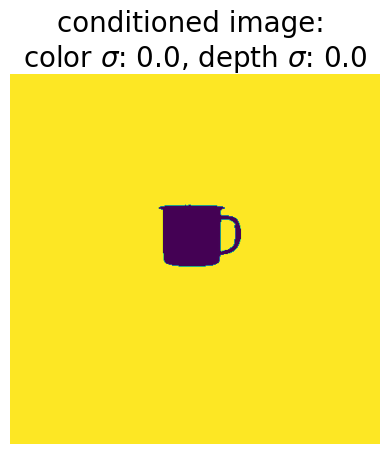

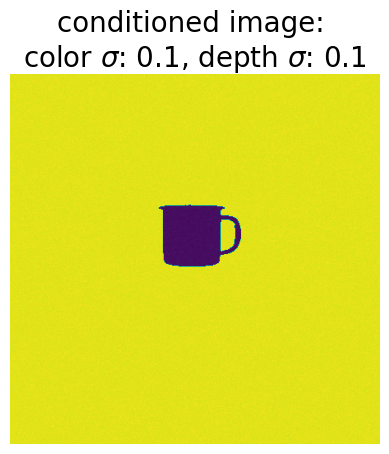

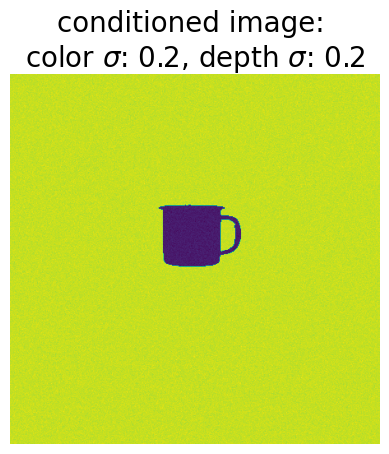

In [ ]:
for noise_ind, (rgb_noise_level, depth_noise_level) in enumerate(zip(rgb_noise_levels, depth_noise_levels)):
    plt.figure()
    plt.title("conditioned image: \ncolor $\sigma$: " + str(rgb_noise_level) + ", depth $\sigma$: " + str(depth_noise_level), fontsize=20)
    plt.imshow(gt_image_depths[noise_ind])
    plt.axis('off')

In [ ]:
len(gt_image_depths)

9